<a href="https://colab.research.google.com/github/pachterlab/CP_2023/blob/main/notebooks/picassoAnalysis_Fig7/merfish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Picasso analysis with the L1 norm

In [ ]:
import requests
import os


from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname


#Pseudotime Packer & Zhu C. elegans data
#counts.mtx
download_file('10.22002/D1.2060','.gz')

#cells.csv
download_file('10.22002/D1.2061','.gz')

#genes.csv
download_file('10.22002/D1.2062','.gz')


#MERFISH data

#metadata.csv
download_file('10.22002/D1.2063','.gz')

#counts.h5ad
download_file('10.22002/D1.2064','.gz')

os.system("gunzip *.gz")

os.system("mv D1.2063 metadata.csv")
os.system("mv D1.2064 counts.h5ad")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/14905 [00:00<?, ?B/s]

  0%|          | 0/561 [00:00<?, ?B/s]

  0%|          | 0/165 [00:00<?, ?B/s]

  0%|          | 0/9784 [00:00<?, ?B/s]

  0%|          | 0/59360 [00:00<?, ?B/s]

0

In [ ]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 145 (delta 78), reused 95 (delta 38), pack-reused 0
Receiving objects: 100% (145/145), 412.94 KiB | 4.69 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [ ]:
%cd /content/densvis/densne/

/content/densvis/densne


In [ ]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient accuracy
   ~~~~~^~~~~~~~~~

In [ ]:
%cd /content/

/content


In [ ]:
!git clone https://github.com/pachterlab/CP_2023.git

Cloning into 'CP_2022'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 205 (delta 93), reused 77 (delta 17), pack-reused 0
Receiving objects: 100% (205/205), 65.03 MiB | 19.43 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [ ]:
%cd /content/CP_2023/scripts

/content/CP_2022/scripts


In [ ]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy

     |████████████████████████████████| 91 kB 3.0 MB/s 
     |████████████████████████████████| 7.7 MB 4.7 MB/s 
     |████████████████████████████████| 86 kB 4.4 MB/s 
     |████████████████████████████████| 1.1 MB 39.7 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


## **Install Packages**

In [ ]:
import statistics
import anndata
import pandas as pd
import numpy as np
from Picasso import Picasso
import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis,NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib

from sklearn.metrics import accuracy_score

matplotlib.rc('axes',edgecolor='black')
%matplotlib inline

sc.set_figure_params(dpi=125)
sns.set_style('white')

## **Import Data**

In [ ]:
# General parameters
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '/content'

n_latent = 50
pcs = 50

In [ ]:
def getAllVars(latents,latentLab,latentType):
  emb = []

  vals = []

  dist = []

  dim = []

  allVals = pd.DataFrame()

  for p in range(len(latents)):

    i = latents[p]
    l = latentLab[p]
    d = latentType[p]

    c = tl.getCentroidDists(i, labs[0])
    intra = tl.getIntraVar(i, labs[0], labs[0])


    vals += [stats.pearsonr(c, amb)[0],stats.pearsonr(intra, ambIntra)[0]]
    dist += ['Inter-Type','Intra-Type']

    emb += [l]*2
    dim += [d]*2

  allVals['Latent'] = emb
  allVals['Distance'] = dist
  allVals['Pearsonr'] = vals
  allVals['Dimension'] = dim

  return allVals

In [ ]:
def getJac(orig_indices,latents, latentLab, n_neighbors=30):
  emb = []

  xs = []

  ys = []

  knnDF = pd.DataFrame()

  for p in range(len(latents)):
    i = latents[p]
    l = latentLab[p]

    ind = tl.getNeighbors(i, n_neigh = n_neighbors,p=1)

    x = tl.getJaccard(orig_indices,ind)

    xs += x
    #ys += list(y)

    emb += [l]*len(x)

    print(l)

    print(np.mean(tl.getJaccard(orig_indices,ind)))



  knnDF['x'] = xs
  #knnDF['y'] = ys
  knnDF['latent'] = emb

  return knnDF

## **Merfish Data**

In [ ]:
counts = anndata.read(data_path+'/counts.h5ad')
print(counts)

cellMeta = pd.read_csv(data_path+'/metadata.csv')
print(cellMeta.head())

AnnData object with n_obs × n_vars = 280327 × 254
     Unnamed: 0  fovID     fov_x  ...     label     subclass    class_label
0  1.000010e+37     13  4539.310  ...   Astro_1   Astrocytes          Other
1  1.000020e+38    290 -4016.860  ...      Endo  Endothelial          Other
2  1.000070e+38    113   750.406  ...       SMC          SMC          Other
3  1.000070e+38    432  1262.680  ...      Endo  Endothelial          Other
4  1.000090e+38    354 -3627.450  ...  L23_IT_3       L23_IT  Glutamatergic

[5 rows x 12 columns]


In [ ]:
axisFontSize = 11
tickFontSize = 10
errwidth=1
figsize =(8,4)
dodge=0.4

In [ ]:
cellMeta.columns

Index(['Unnamed: 0', 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x',
       'center_y', 'slice_id', 'sample_id', 'label', 'subclass',
       'class_label'],
      dtype='object')

In [ ]:
choice = np.unique(cellMeta.slice_id)[7] #7
choice

'mouse1_slice162'

In [ ]:
counts.obs['slice'] = pd.Categorical(cellMeta.slice_id)
counts.obs['type'] = pd.Categorical(cellMeta.subclass)
counts.obs['x'] = list(cellMeta.center_x)
counts.obs['y'] = list(cellMeta.center_y)


In [ ]:
sub = counts[counts.obs['slice'].isin([choice])]
print(sub)

#colors = np.random.rand(len(sub.obs['type']),3)
nanLabs = np.array([[np.nan]*len(sub.obs['type'])])

labs = np.array([list(sub.obs['type'])])
labs_cont = np.array([list(sub.obs['x']),list(sub.obs['y'])])

View of AnnData object with n_obs × n_vars = 6963 × 254
    obs: 'slice', 'type', 'x', 'y'


In [ ]:
#colors = np.random.rand(len(adata2.obs['Cluster']),3)
cdict = {'Microglia':'#A778BC','L6_IT':'#EA95C1','Astrocytes':'#B6657E','Oligodendrocytes':'#B49599',
         'L23_IT':'#628EA2','OPC':'#72B9A5','L45_IT':'#71B7A2','Endothelial':'#7794C3','Pvalb':'#FD8085',
         'L6_IT_Car3':'#FAD1FC','L56_NP':'#93B09B','PVM':'#ECBDD2','L5_IT':'#ABA8DF',
         'L5_PT':'#D36486','Sst':'#8FE0B1','L6_CT':'#9589C4','Vip':'#CD83AC','VLMC':'#BBDBF2',
         'SMC':'#7A849E','other':'#A382BC','L6b':'#64D7F0','Pericytes':'#95BA98',
         'Lamp5':'#A3E169','Sncg':'#92B1DB','Sst_Chodl':'#81FAC9'}
colors = [cdict[i] for i in pd.unique(sub.obs['type'])]

In [ ]:
sub.obs['type'].value_counts()

L45_IT              977
L23_IT              946
L6_CT               582
Astrocytes          546
Oligodendrocytes    522
Endothelial         505
L5_IT               441
L6_IT               439
other               204
Pericytes           195
L5_PT               185
Microglia           182
Pvalb               167
PVM                 164
VLMC                139
OPC                 131
L6_IT_Car3          123
SMC                 119
L6b                 104
Sst                  92
L56_NP               78
Lamp5                59
Vip                  53
Sncg                  5
Sst_Chodl             5
Name: type, dtype: int64

Make log-normalized, and scaled count matrices (separately)

In [ ]:
orig_mat = sub.X

In [ ]:
log_mat = np.log1p(sub.X)

In [ ]:
sc.pp.log1p(sub)

#Center scale
sc.pp.scale(sub, max_value=10)

scaled_mat = sub.X

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
amb = tl.getCentroidDists(log_mat,labs[0])
ambIntra = tl.getIntraVar(log_mat, labs[0],labs[0])

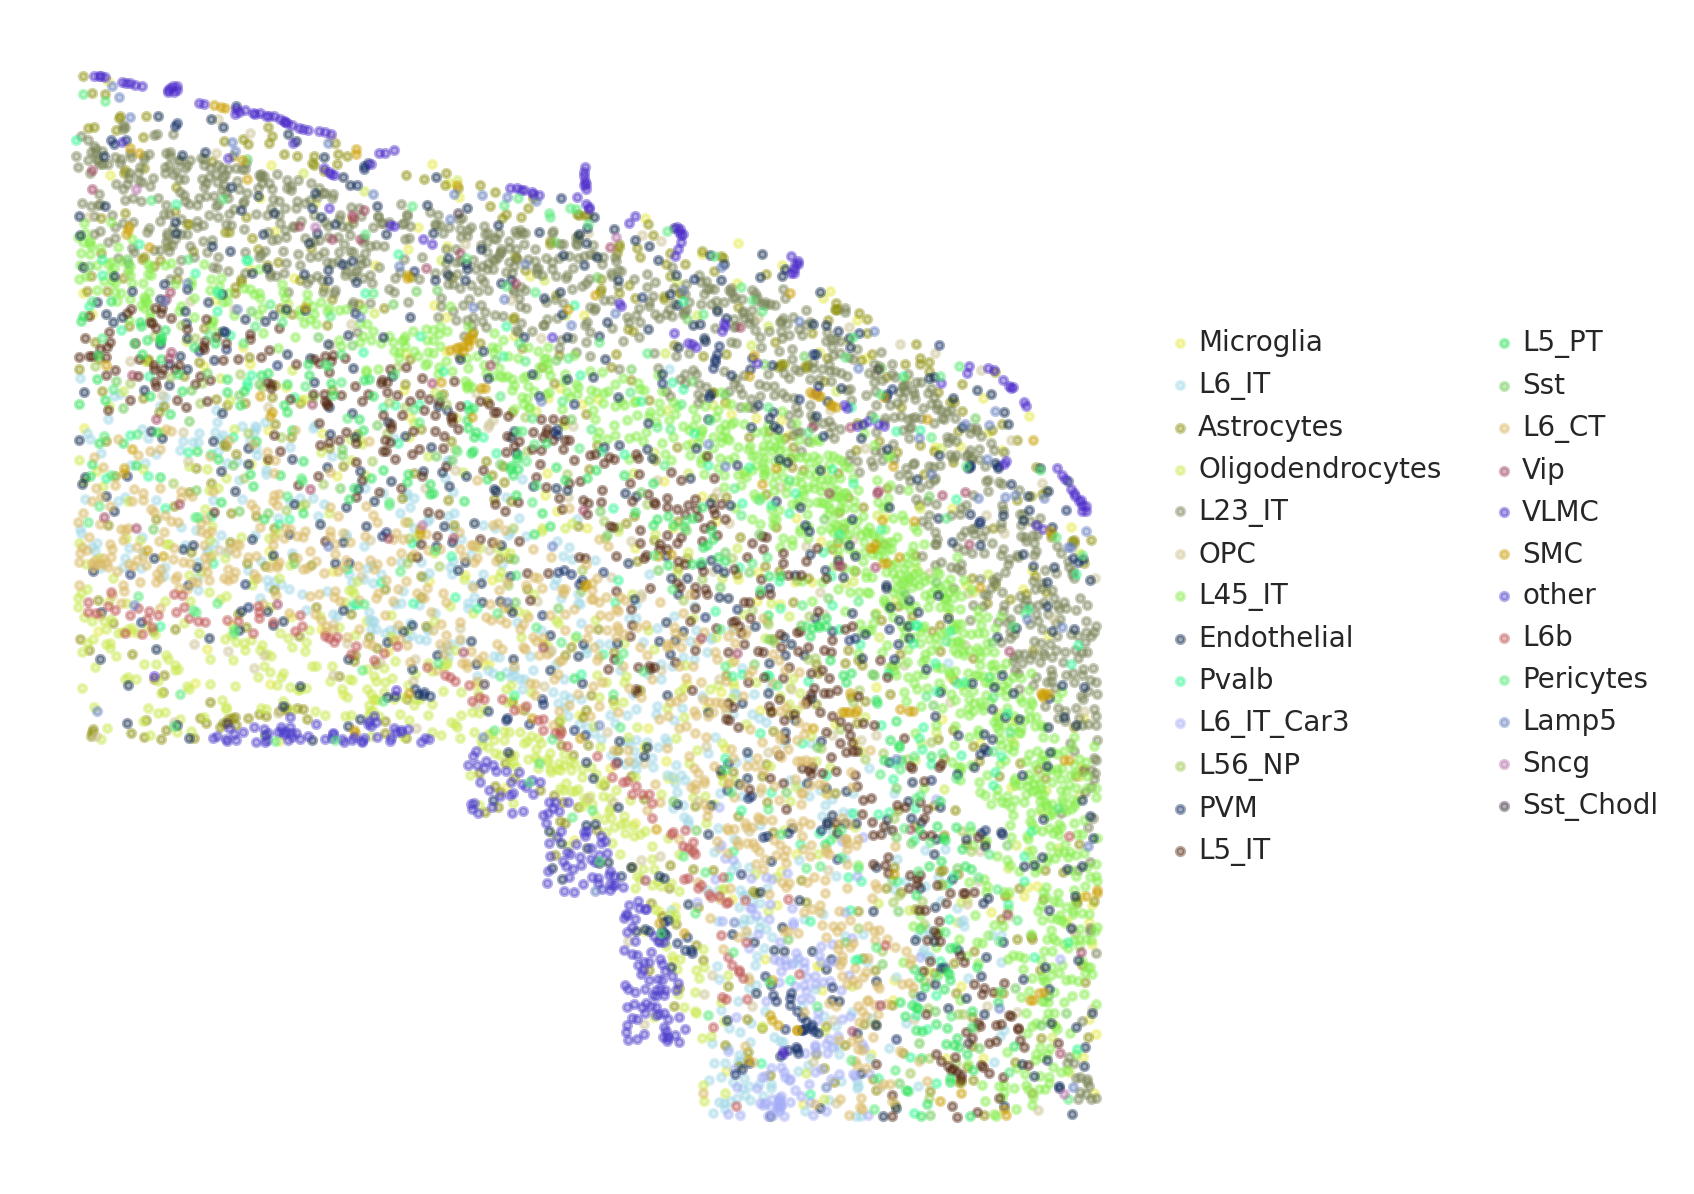

In [ ]:
vis.obj_plot_embed(labs_cont.T, labs[0], fname = '2DNCA.pdf', colors=colors )

### **Picasso Analysis**

In [ ]:
rounds = 5

Generate 2D coordinates for shape

In [ ]:
batch_size = 128 #len(sub.obs_names)
#Make a (unit) circle
#r = 1
theta = np.linspace(0, 2*np.pi, batch_size)
# #Turkey guy
# x, y = (np.sin(2**theta) - 1.7) * np.cos(theta), (np.sin(2**theta) - 1.7) * np.sin(theta)

# #Butterfly r = 4*cos(4cosθ))
# x, y = (2*np.cos(4*np.cos(theta))) * np.cos(theta), (2*np.cos(4*np.cos(theta))) * np.sin(theta)

# # Spiral
#x, y = (1/2)*theta * np.cos(theta), (1/2)*theta * np.sin(theta)

# #Quasi-rose
#x, y = 0.2*(4 + np.cos(6*theta)) * np.cos(theta), 0.3*(4 + np.cos(6*theta)) * np.sin(theta)
x, y = (4 + np.cos(6*theta)) * np.cos(theta), (4 + np.cos(6*theta)) * np.sin(theta)

#Make array input for dimension of shape
coords = np.array([list(x),list(y)])

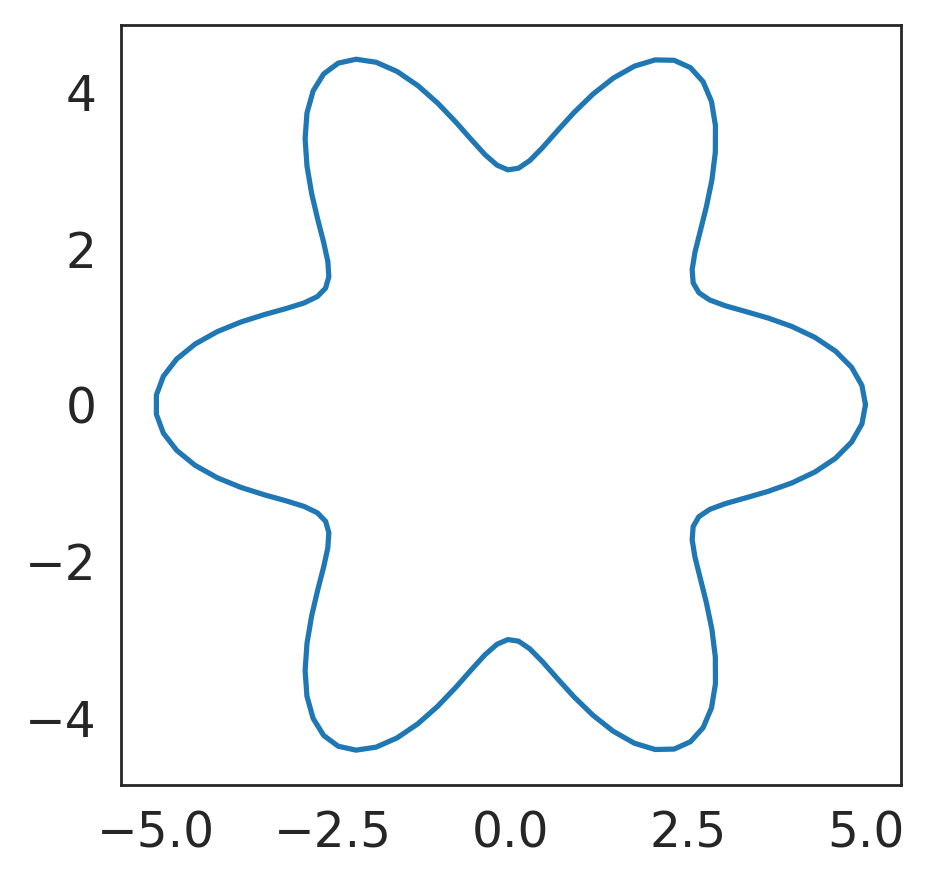

In [ ]:
plt.plot(x,y)

In [ ]:

# fl = []
# flLab = []
# flType = []

# for i in range(rounds):
#   nca = Picasso(n_latent = 2, epochs =500) #100 batch_size = batch_size
#   losses1, latent1 = nca.fit(scaled_mat,coords, frac = 0.2,silent=True,ret_loss=True)

#   fl += [latent1]
#   flLab += ['Flower']
#   flType += ['MCML 2D']


Run Picasso fit

In [ ]:
#Task assignment,

fl = []
flLab = []
flType = []

for i in range(rounds):
  nca = Picasso(n_latent = 2, epochs =500) #100 batch_size = batch_size
  losses1, latent1 = nca.fit(scaled_mat,coords, frac = 0.2,silent=True,ret_loss=True)

  fl += [latent1]
  flLab += ['Flower']
  flType += ['MCML 2D']



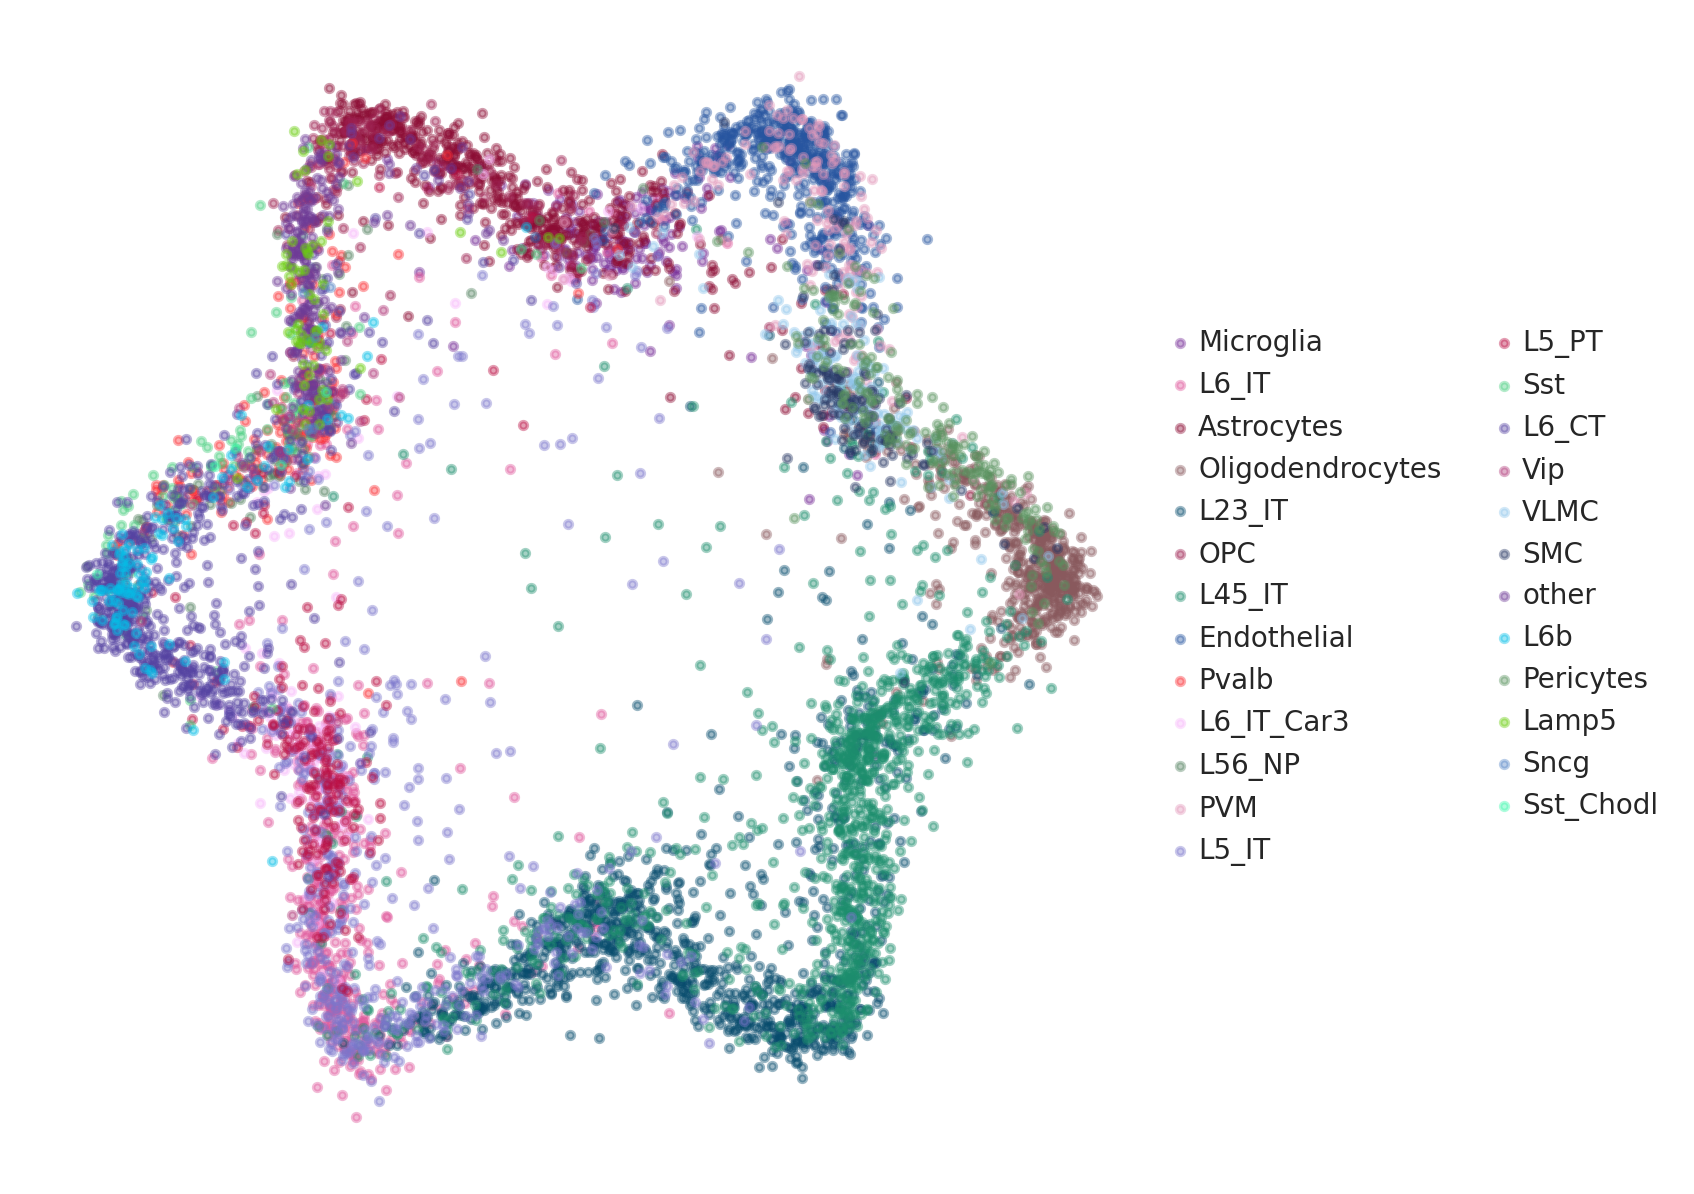

In [ ]:



vis.obj_plot_embed(latent1, labs[0], fname = '2DNCA.pdf', colors=colors )


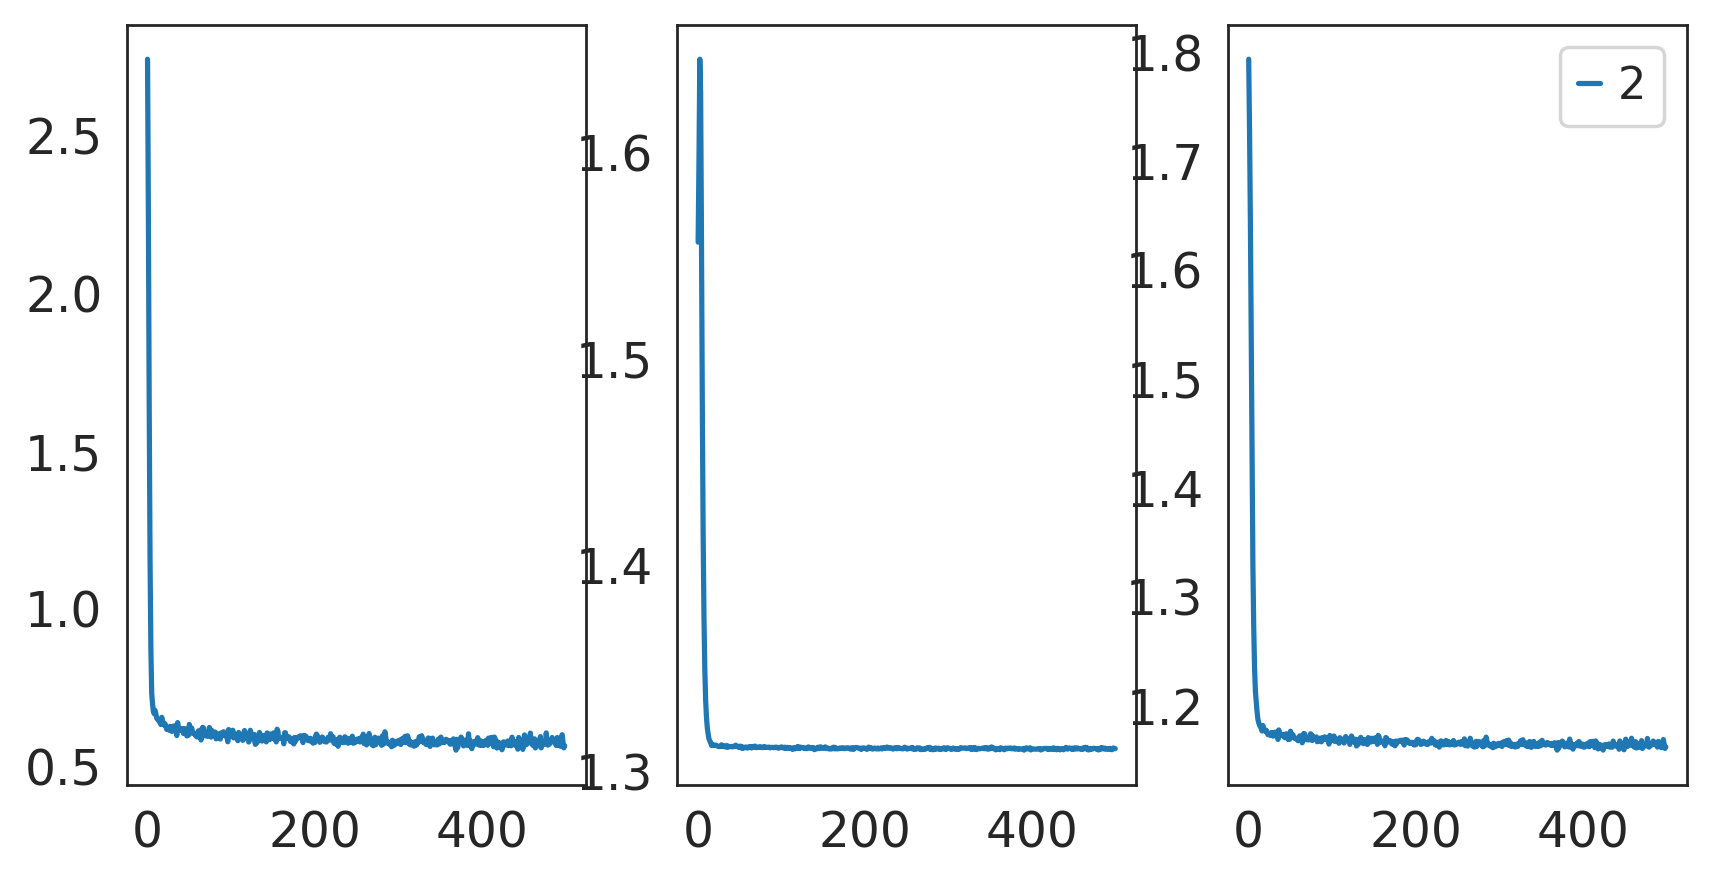

In [ ]:
nca.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

Check overfitting

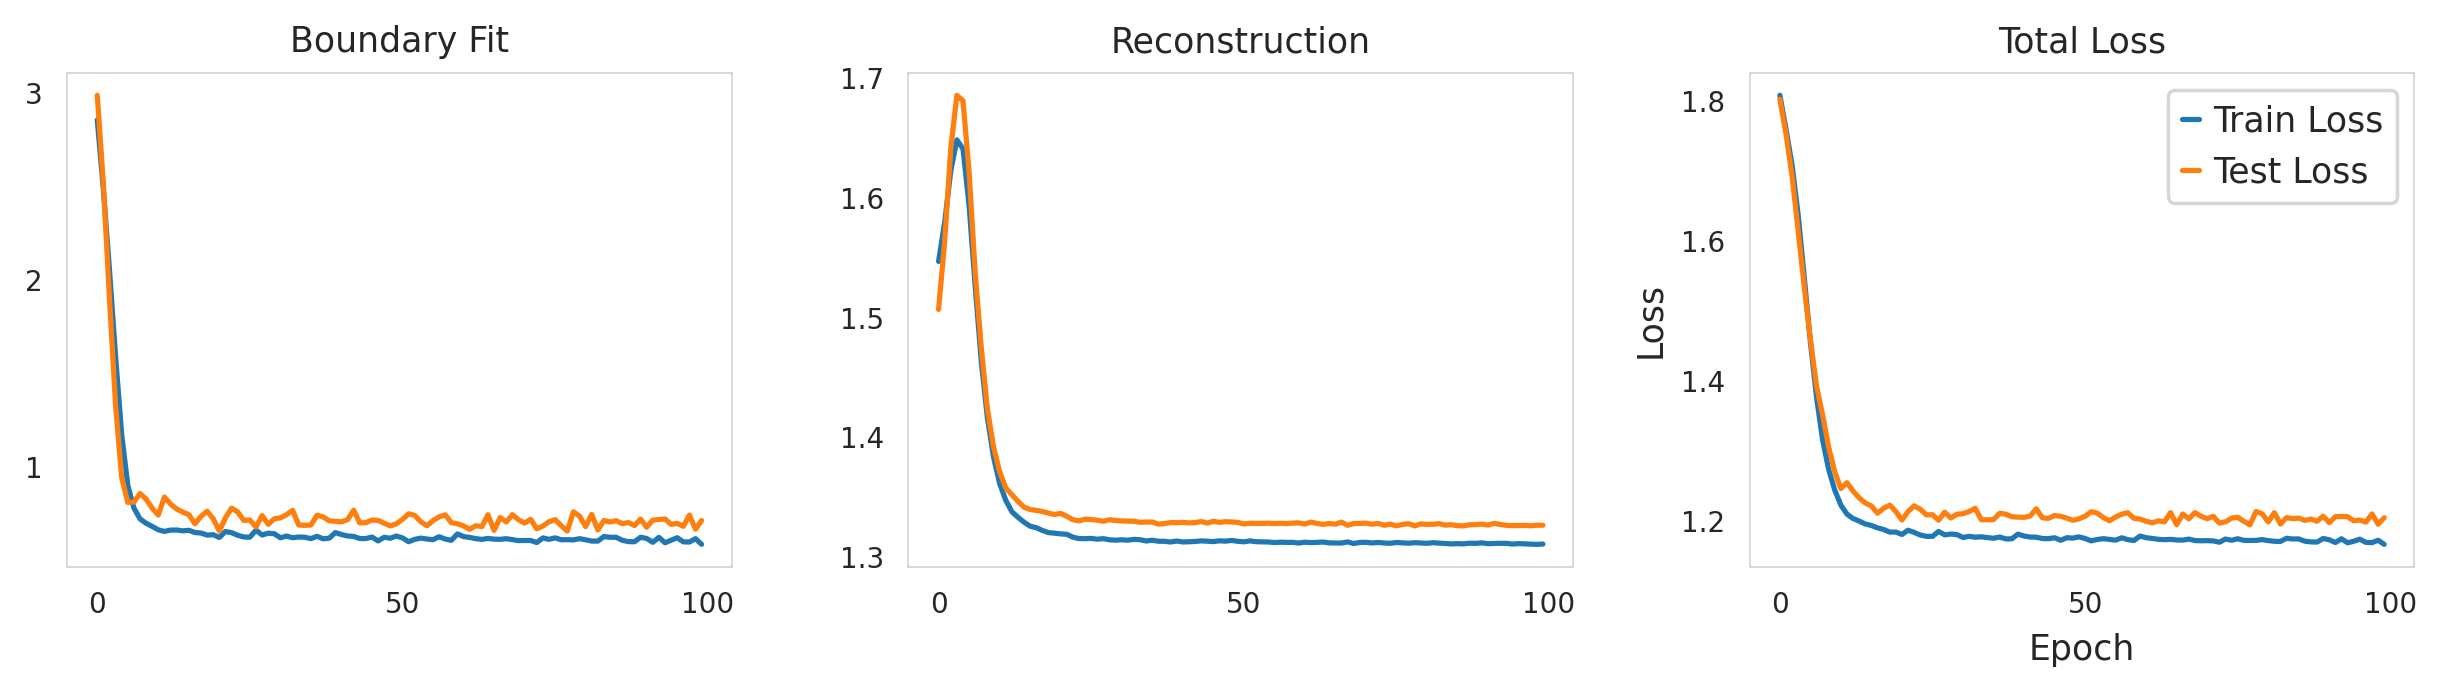

In [ ]:
nca = Picasso(n_latent = 2, epochs = 100)

lossesTrain, lossesTest = nca.trainTest(scaled_mat,coords,frac = 0.2, silent = True)
nca.plotLosses(figsize=(10,3),fname='merfishFlowerTrainTest.pdf',axisFontSize=10,tickFontSize=8)

Generate 2D Elephant coordinates: see https://www.johndcook.com/blog/2011/06/21/how-to-fit-an-elephant/

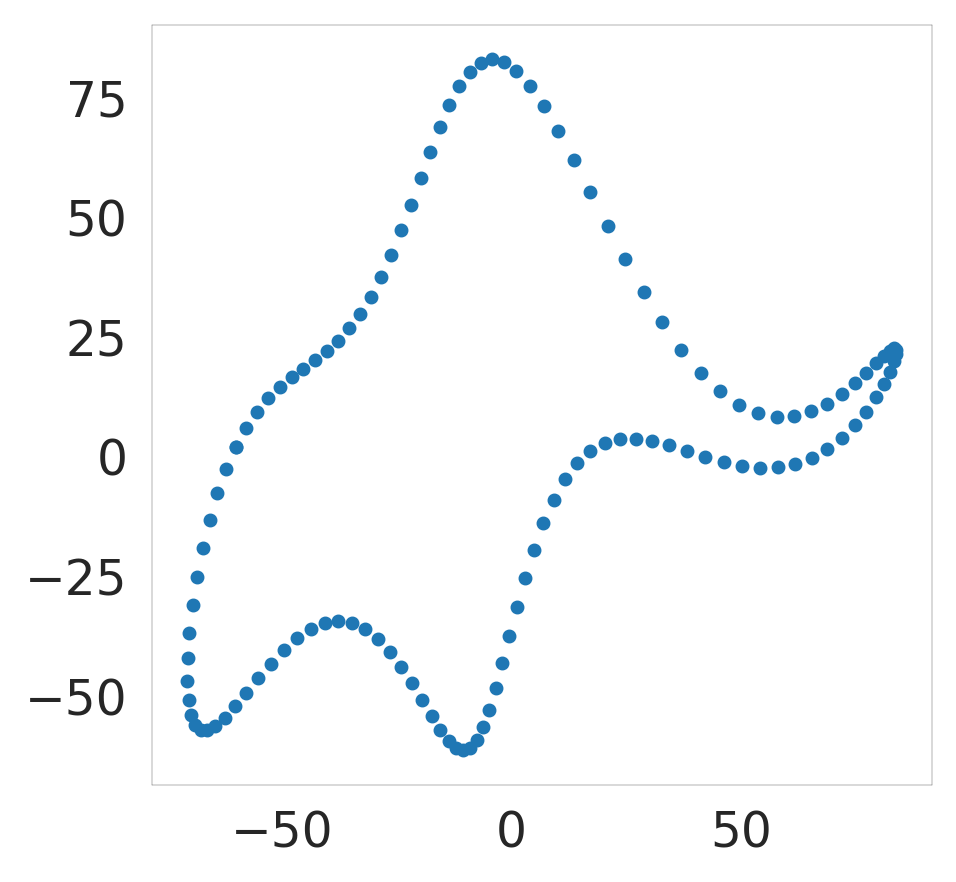

In [ ]:
# elephant parameters --- see https://www.johndcook.com/blog/2011/06/21/how-to-fit-an-elephant/ ---
batch_size = 128#len(sub.obs_names)

p1, p2, p3, p4 = (50 - 30j, 18 +  8j, 12 - 10j, -14 - 60j )
p5 = 40 + 20j # eyepiece

def fourier(t, C):
    f = np.zeros(t.shape)
    A, B = C.real, C.imag
    for k in range(len(C)):
        f = f + A[k]*np.cos(k*t) + B[k]*np.sin(k*t)
    return f

def elephant(t, p1, p2, p3, p4, p5):
    npar = 6
    Cx = np.zeros((npar,), dtype='complex')
    Cy = np.zeros((npar,), dtype='complex')

    Cx[1] = p1.real*1j
    Cx[2] = p2.real*1j
    Cx[3] = p3.real
    Cx[5] = p4.real

    Cy[1] = p4.imag + p1.imag*1j
    Cy[2] = p2.imag*1j
    Cy[3] = p3.imag*1j

    # x = np.append(fourier(t,Cx), [-p5.imag]) #[-p5.imag]
    # y = np.append(fourier(t,Cy), [p5.imag]) #[p5.imag]
    x = fourier(t,Cx)
    y = fourier(t,Cy)

    return x,y

x, y = elephant(np.linspace(0,2*np.pi,batch_size), p1, p2, p3, p4, p5)

y = y#0.015*y
x = x#0.015*x

coords = np.array([list(y),list(-x)])

plt.plot(y,-x,'.')
plt.show()


Run Picasso fit

In [ ]:
#Task assignment, try 500
el = []
elLab = []
elType = []

for i in range(rounds):
  nca = Picasso(n_latent = 2, epochs =500)
  lossesEl, latentEl = nca.fit(scaled_mat,coords, frac = 0.15,silent=True,ret_loss=True)

  el += [latentEl]
  elLab += ['Elephant']
  elType += ['MCML 2D']

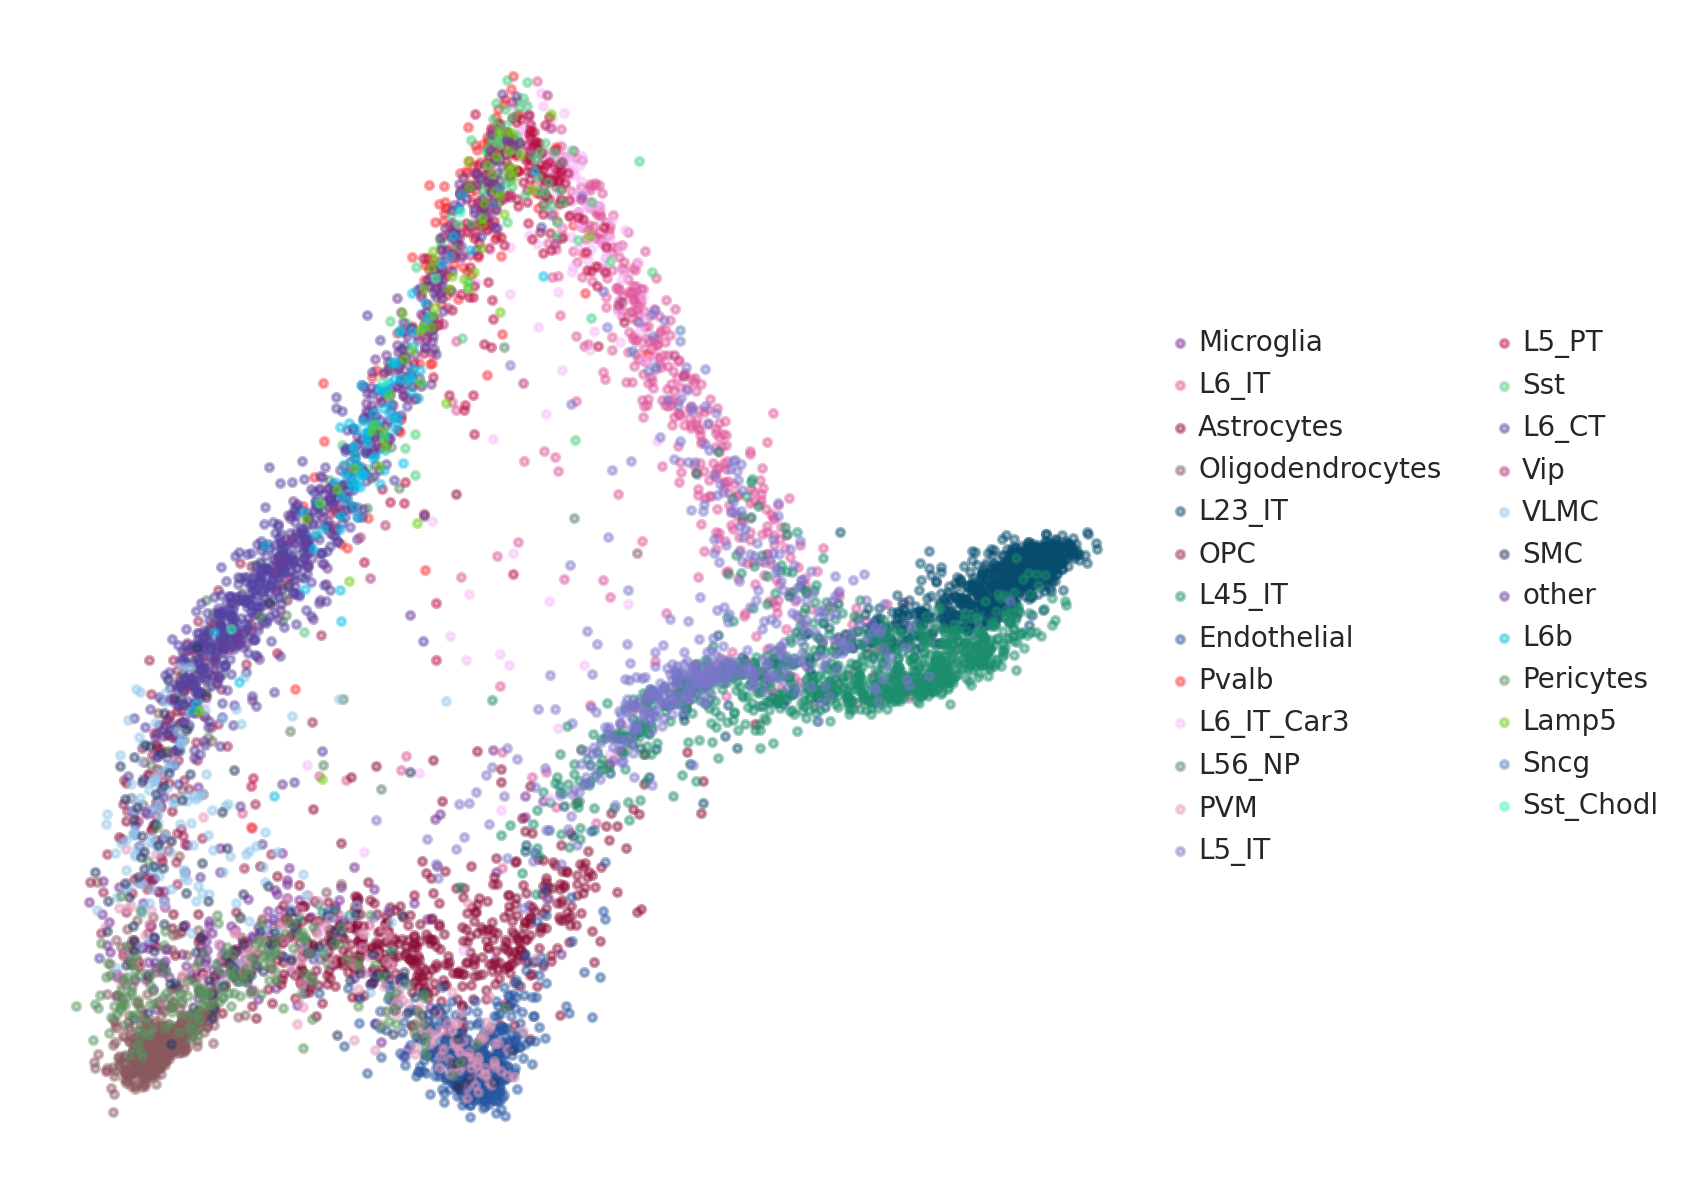

In [ ]:


vis.obj_plot_embed(latentEl, labs[0], fname = '2DNCA.pdf', colors=colors )


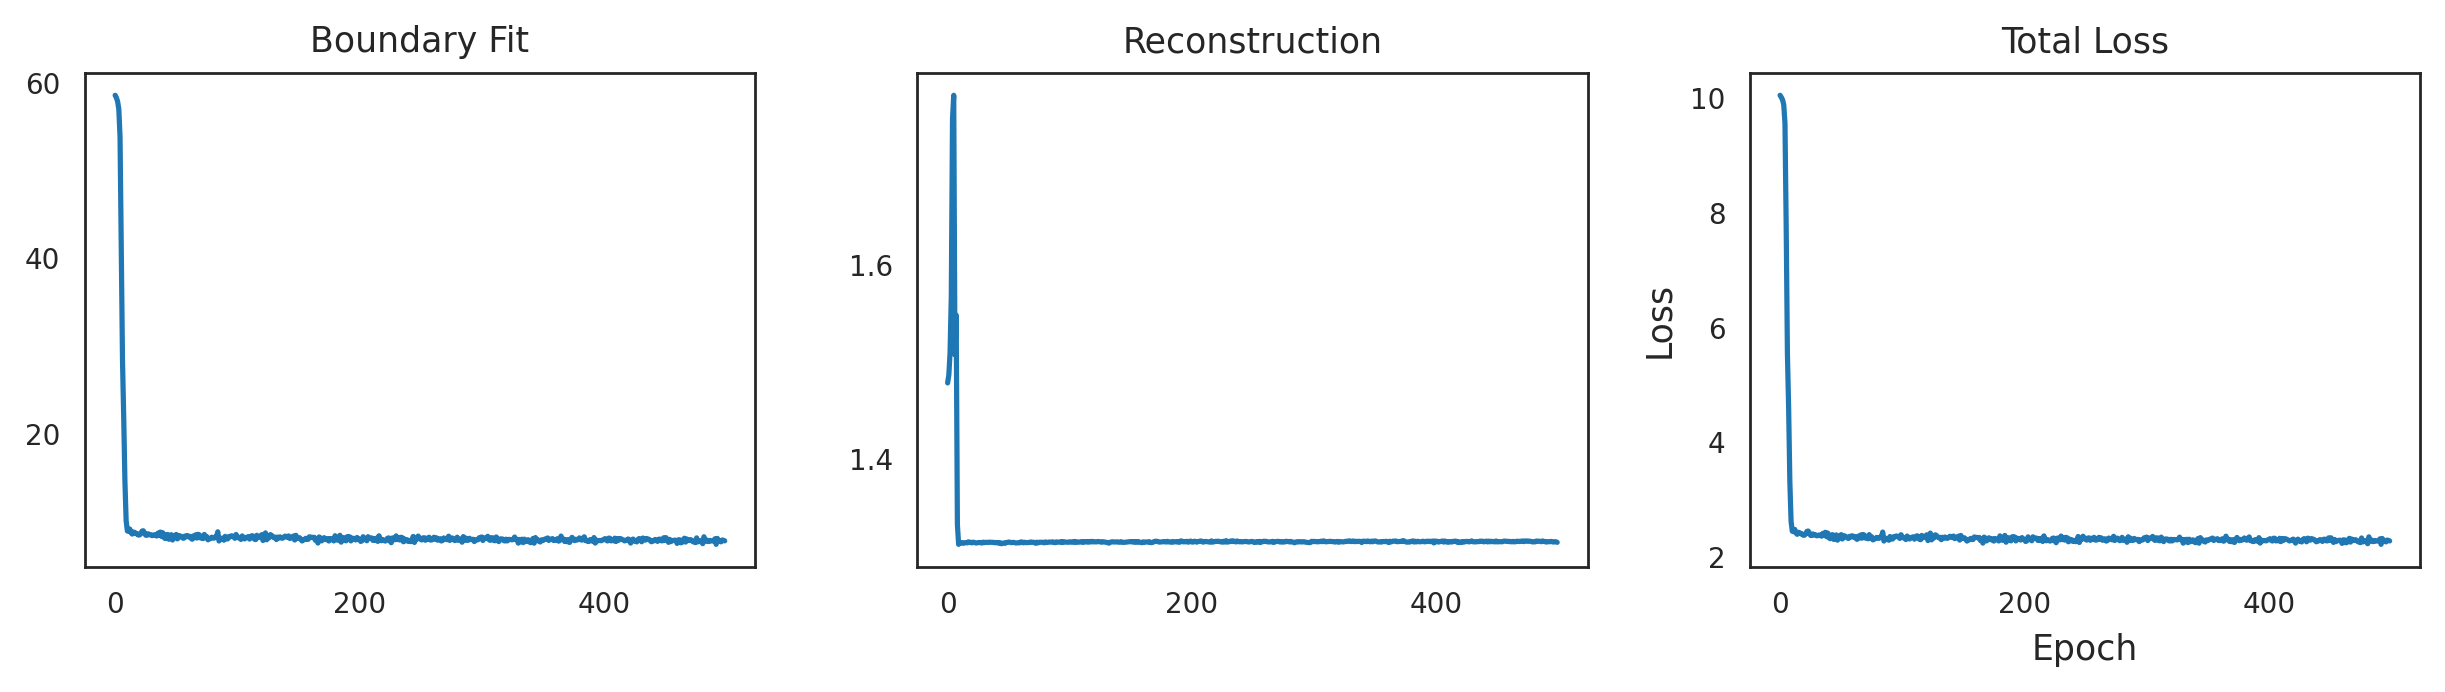

In [ ]:
nca.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

Save KNN Jaccard Dists for generated embeddings

In [ ]:
orig_indices = tl.getNeighbors(log_mat, n_neigh = 30,p=1)

In [ ]:
df = getJac(orig_indices,fl+el, flLab+elLab, 30)
df.to_csv('merPicAmb.csv')

Flower
0.9541921521278358
Flower
0.9554134637801598
Flower
0.9530340792058527
Elephant
0.9546787421435631
Elephant
0.9564289283250262
Elephant
0.956604902816918


In [ ]:
from google.colab import files
files.download("merPicAmb.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check overfitting

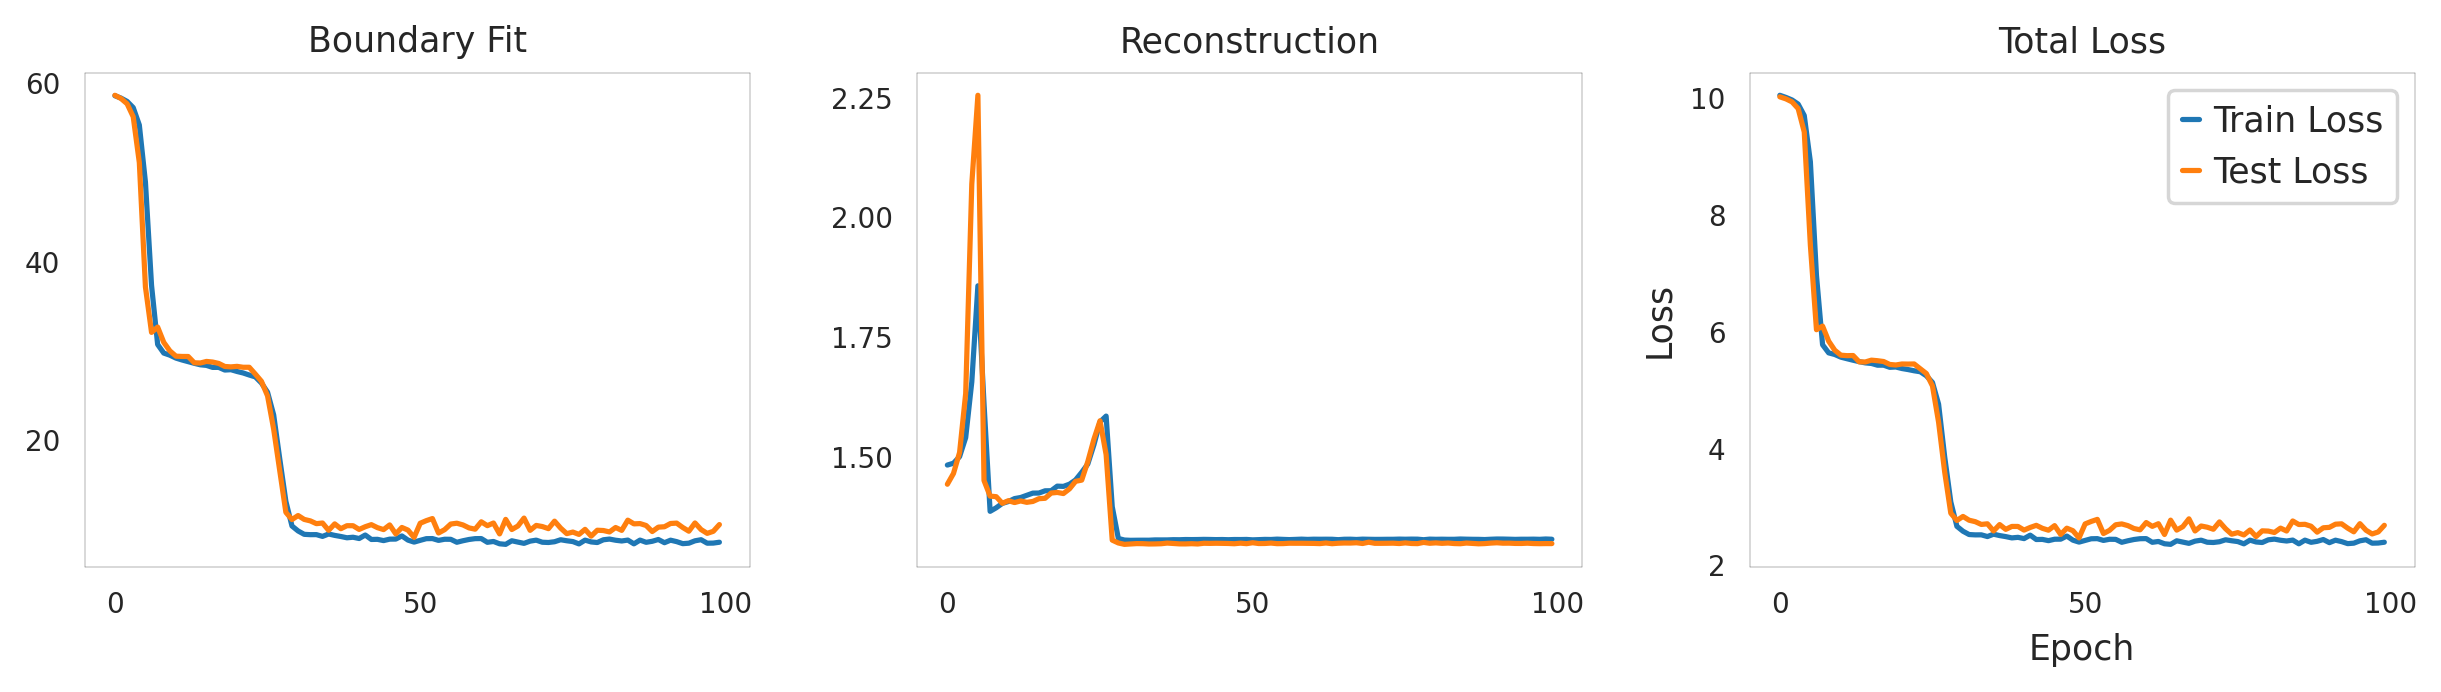

In [ ]:
nca = Picasso(n_latent = 2, epochs = 100)

lossesTrain, lossesTest = nca.trainTest(scaled_mat,coords,frac = 0.15, silent = True)
nca.plotLosses(figsize=(10,3),fname='merfishElephantTrainTest.pdf',axisFontSize=10,tickFontSize=8)

Run Picasso with only 1 round of training

In [ ]:
# #Try with no learning
#batch_size = len(x)
rounds = 5

noT = []
noTLab = []
noTType = []

for i in range(rounds):

  nca = Picasso(n_latent = 2, epochs = 0 ) #batch_size = batch_size
  lossesNoT, latentNoT = nca.fit(scaled_mat,coords, frac = 1,silent=True,ret_loss=True)

  noT += [latentNoT]
  noTLab += ['No Training']
  noTType += ['Picasso 2D']



# vis.obj_plot_embed(latentNoT, meta.smartseq_cluster, fname = '2DNCA.pdf', colors=clus_colors )


Get metrics for Ambient Data

In [ ]:
amb = tl.getCentroidDists(log_mat,labs[0])
ambIntra = tl.getIntraVar(log_mat, labs[0],labs[0])


Create Latent Spaces for Metric Comparisons (Baselines)

In [ ]:
latents,latentLab,latentType = tl.visComp(scaled_mat, ndims=2, pcs=50)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
def plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10, errwidth=1, figsize =(8,4), dodge=0.4, fname = None):
	plt.figure(figsize=figsize)
	g=sns.pointplot(x='Distance', y='Pearsonr', data=allVals, hue='Latent', err_style='bars',join=False,plot_kws=dict(alpha=0.6),errwidth=errwidth, dodge=dodge)
	plt.setp(g.collections, alpha=.6) #for the markers
	plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":10})



	plt.xlabel("Distance Metric",fontsize=axisFontSize)
	plt.ylabel("Pearsonr (to Ambient)",fontsize=axisFontSize)
	plt.xticks(fontsize=tickFontSize)
	plt.yticks(fontsize=tickFontSize)
	plt.tight_layout()

	if(fname != None):
		plt.savefig(fname)
	else:
		plt.show()

Compare No Training Accuracy

In [ ]:
latentsnoT = noT + latents

latentLabnoT = noTLab + latentLab

latentTypenoT = noTType + latentType

In [ ]:
allVals = getAllVars(latentsnoT,latentLabnoT,latentTypenoT )
allVals = allVals[~allVals['Latent'].isin(['PCA 50D'])]

In [ ]:
allVals['Latent'] = [i.replace('TSNE','t-SNE') for i in allVals['Latent']]
allVals['Latent'] = [i.replace('densSNE','dens-SNE') for i in allVals['Latent']]

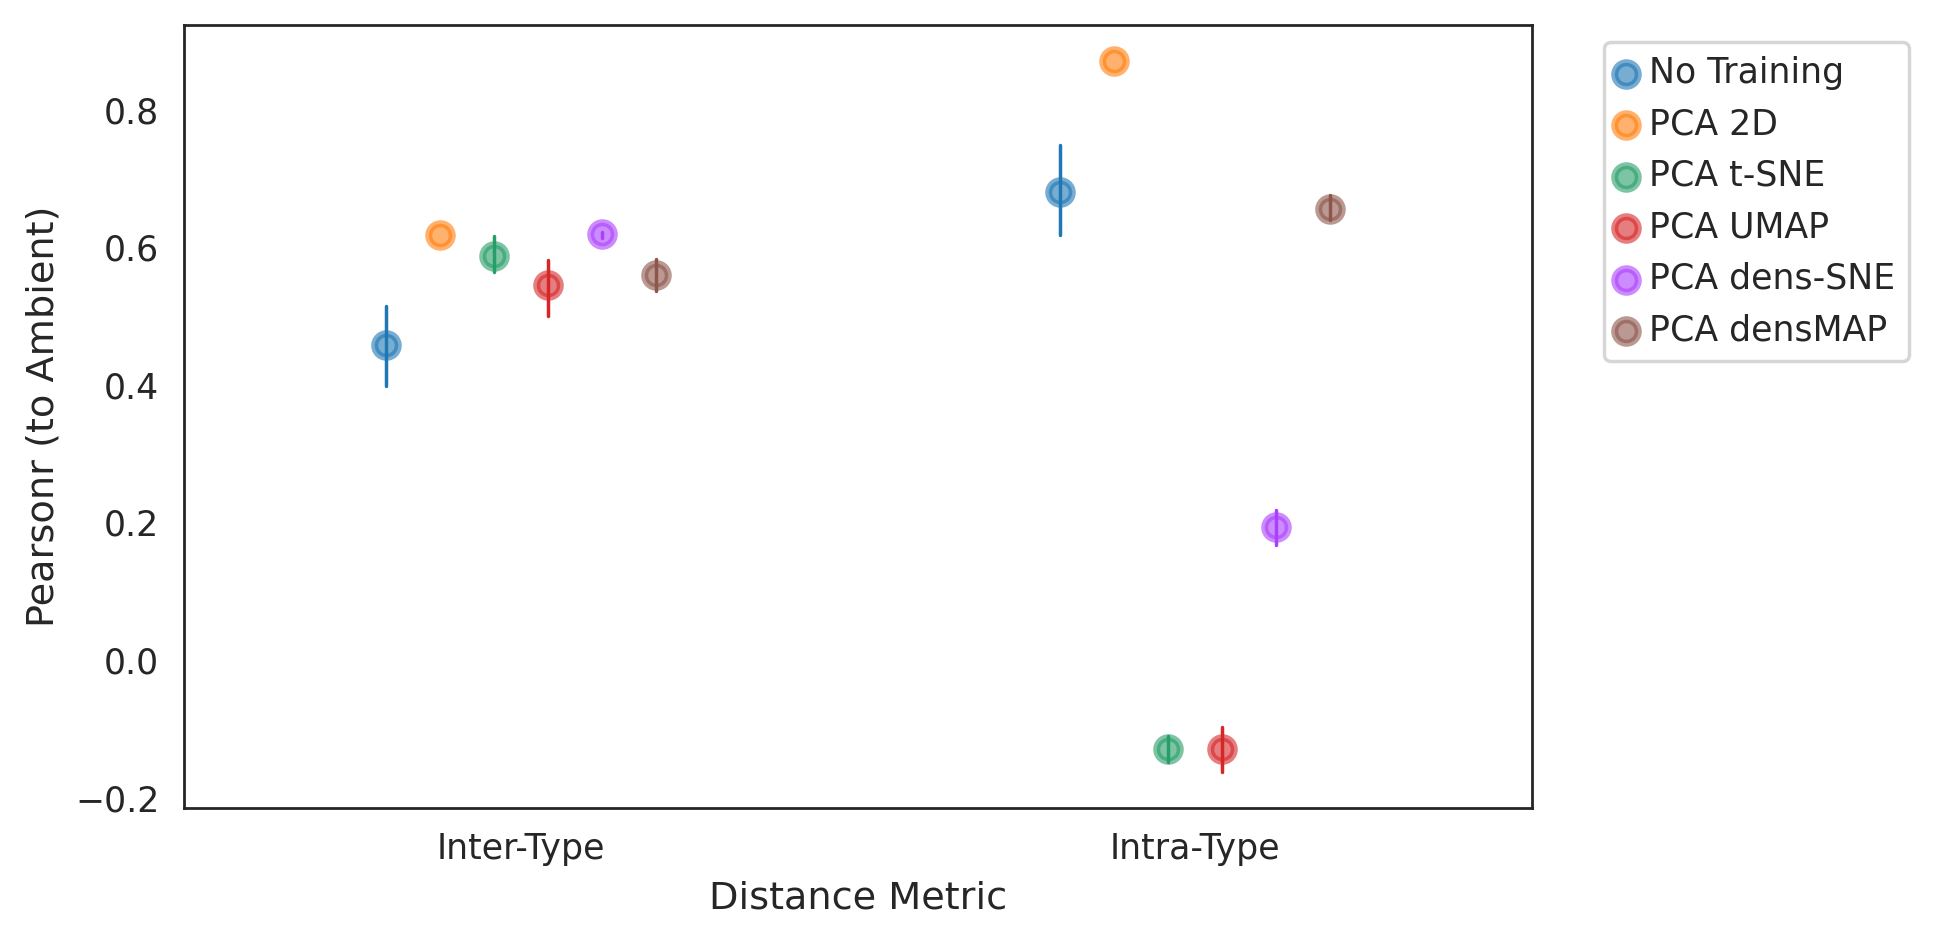

In [ ]:
plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10)

Compare Flower Embedding Accuracy

In [ ]:
latents = fl + latents

latentLab = flLab + latentLab

latentType = flType + latentType

In [ ]:
emb = []

vals = []

dist = []

dim = []

allVals = pd.DataFrame()

for p in range(len(latents)):

  i = latents[p]
  l = latentLab[p]
  d = latentType[p]

  c = tl.getCentroidDists(i, labs[0])
  intra = tl.getIntraVar(i, labs[0], labs[0])


  vals += [stats.pearsonr(c, amb)[0],stats.pearsonr(intra, ambIntra)[0]]
  dist += ['Inter-Type','Intra-Type']

  emb += [l]*2
  dim += [d]*2

allVals['Latent'] = emb
allVals['Distance'] = dist
allVals['Pearsonr'] = vals
allVals['Dimension'] = dim


In [ ]:
allVals = allVals[~allVals['Latent'].isin(['PCA 50D','Elephant'])]

In [ ]:
toRemove = ['Recon MCML denSNE','PCA densSNE','Recon MCML densMAP','PCA densMAP']
subAllVals = allVals[~allVals['Latent'].isin(toRemove)]

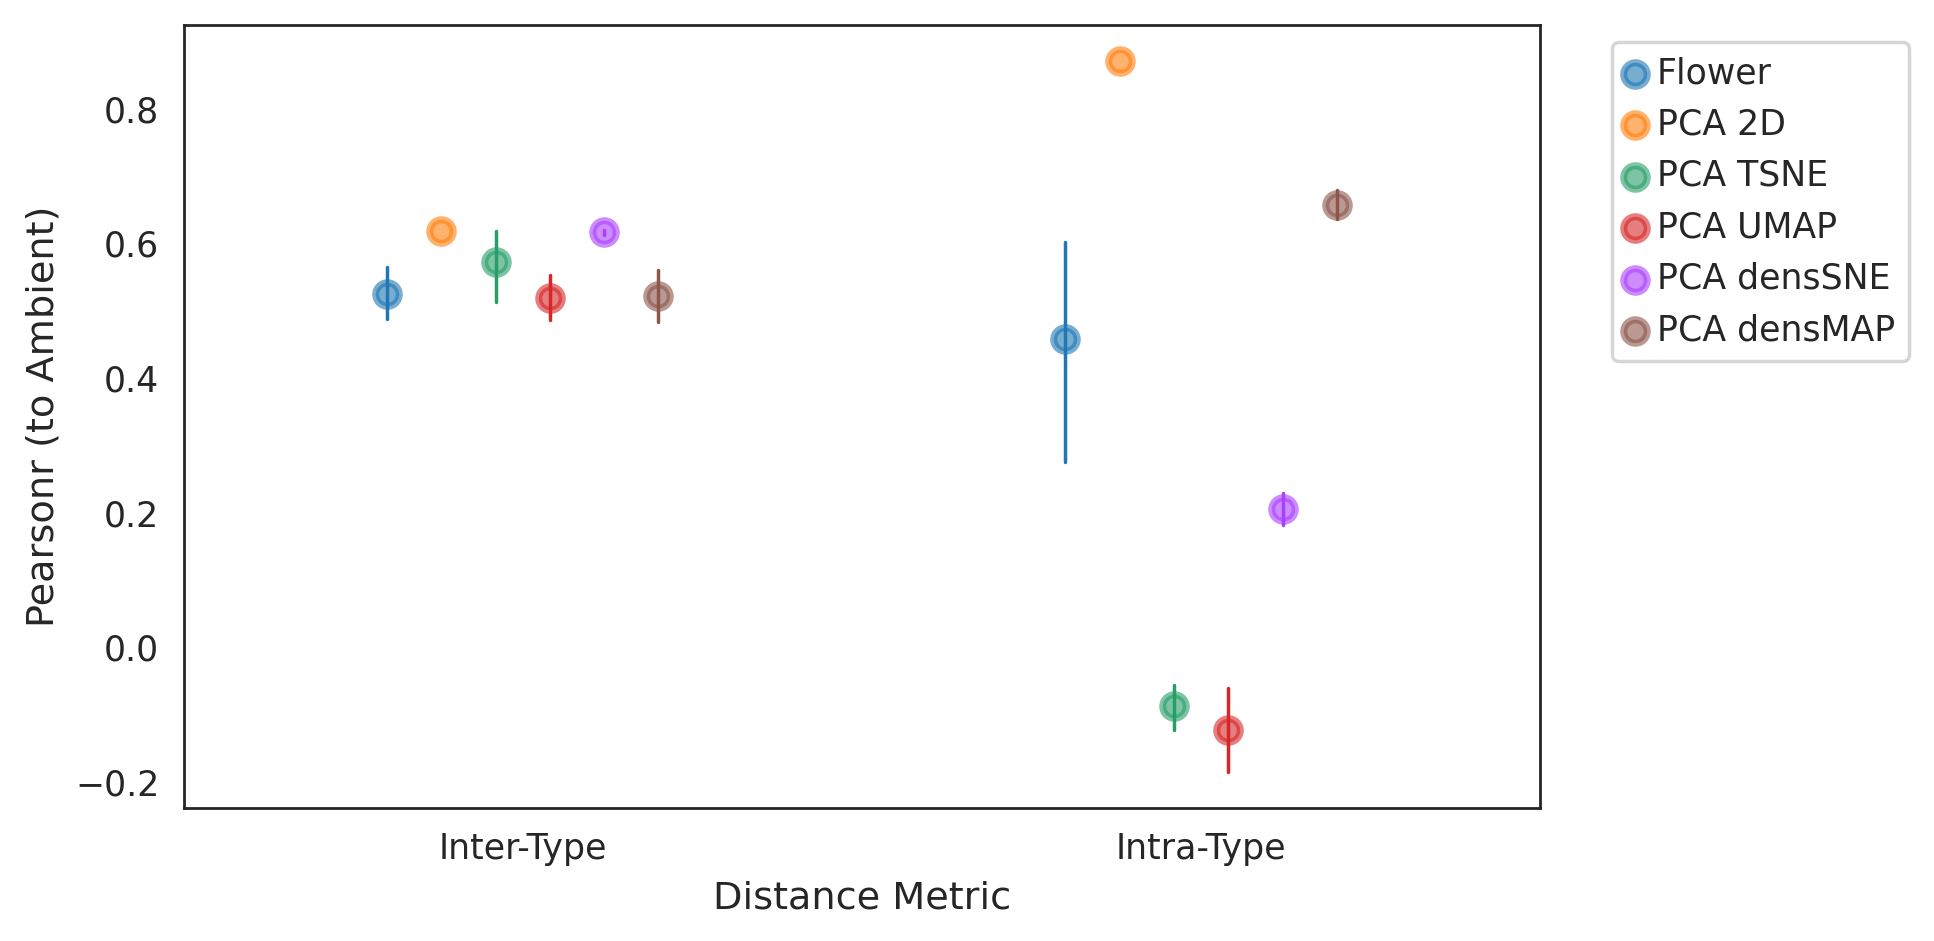

In [ ]:
plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10)

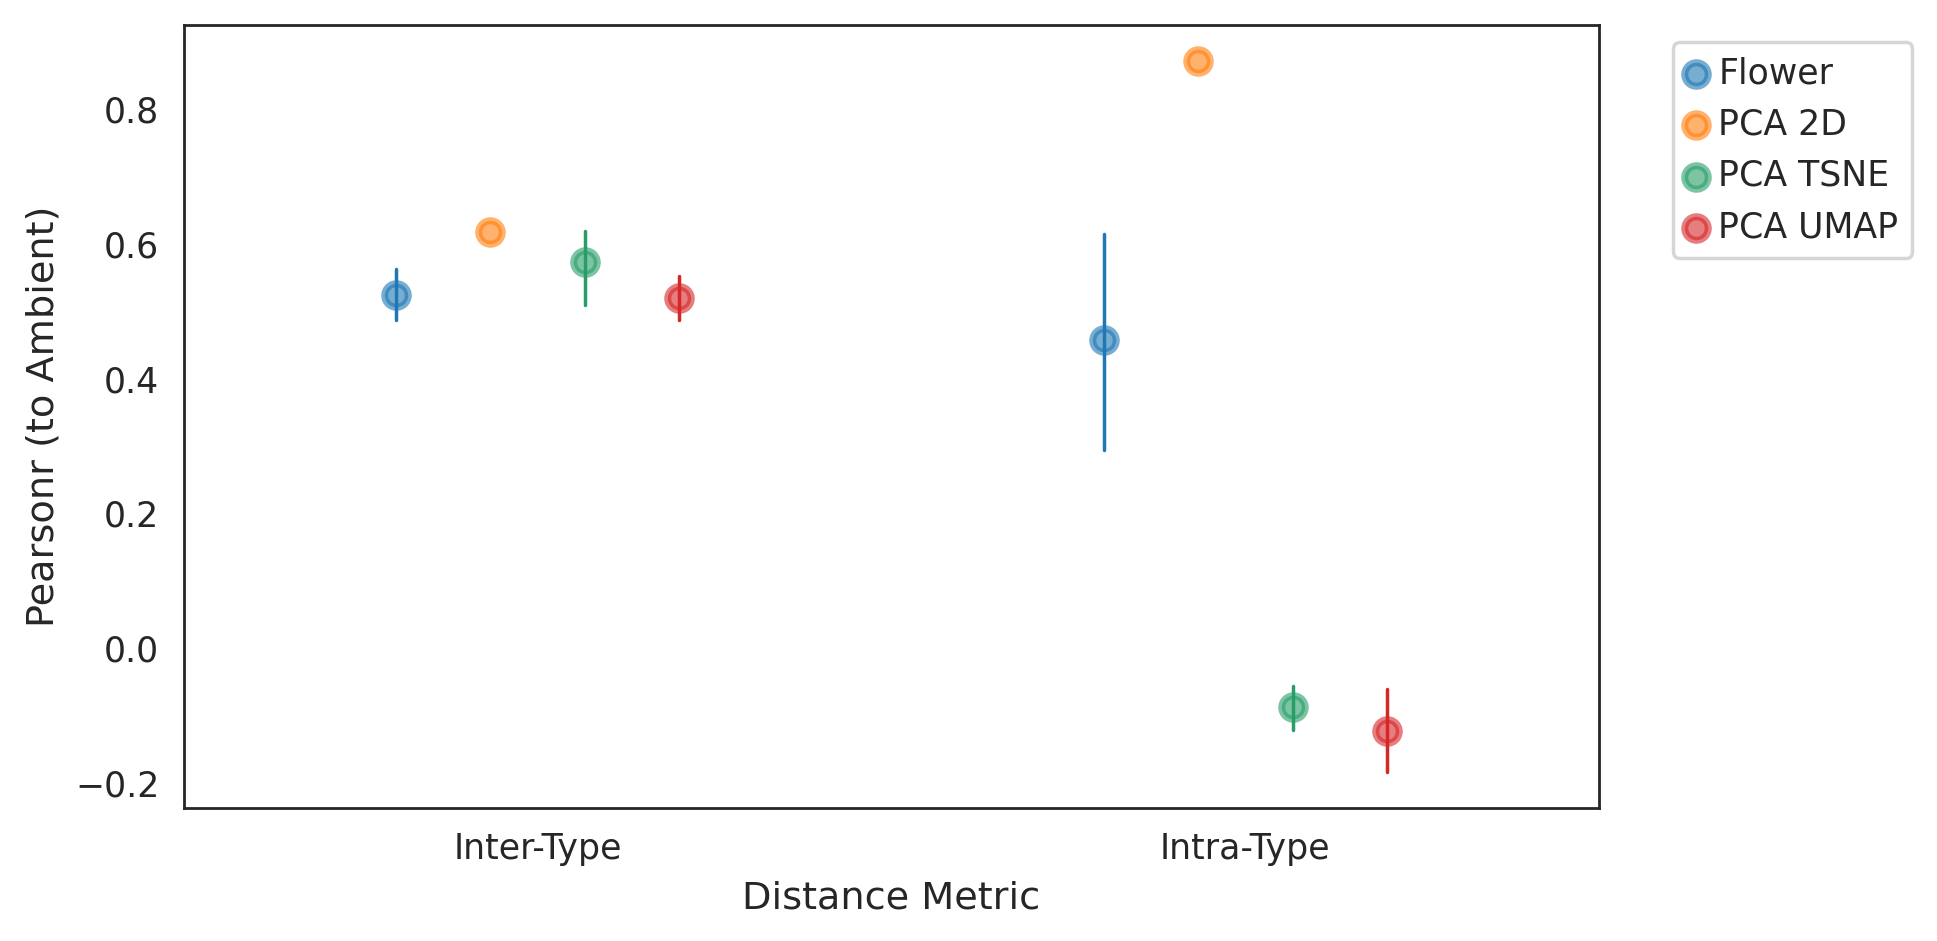

In [ ]:
plotLatentStats(subAllVals, axisFontSize = 11, tickFontSize = 10)

Compare Elephant Embedding Accuracy

In [ ]:
latents = el + latents #[5:]

latentLab = elLab + latentLab #[5:]

latentType = elType + latentType #[5:]

In [ ]:
emb = []

vals = []

dist = []

dim = []

allVals = pd.DataFrame()

for p in range(len(latents)):

  i = latents[p]
  l = latentLab[p]
  d = latentType[p]

  c = tl.getCentroidDists(i, labs[0])
  intra = tl.getIntraVar(i, labs[0], labs[0])


  vals += [stats.pearsonr(c, amb)[0],stats.pearsonr(intra, ambIntra)[0]]
  dist += ['Inter-Type','Intra-Type']

  emb += [l]*2
  dim += [d]*2

allVals['Latent'] = emb
allVals['Distance'] = dist
allVals['Pearsonr'] = vals


In [ ]:
allVals = allVals[~allVals['Latent'].isin(['Flower','PCA 50D'])]

In [ ]:
toRemove = ['Recon MCML denSNE','PCA densSNE','Recon MCML densMAP','PCA densMAP']
subAllVals = allVals[~allVals['Latent'].isin(toRemove)]

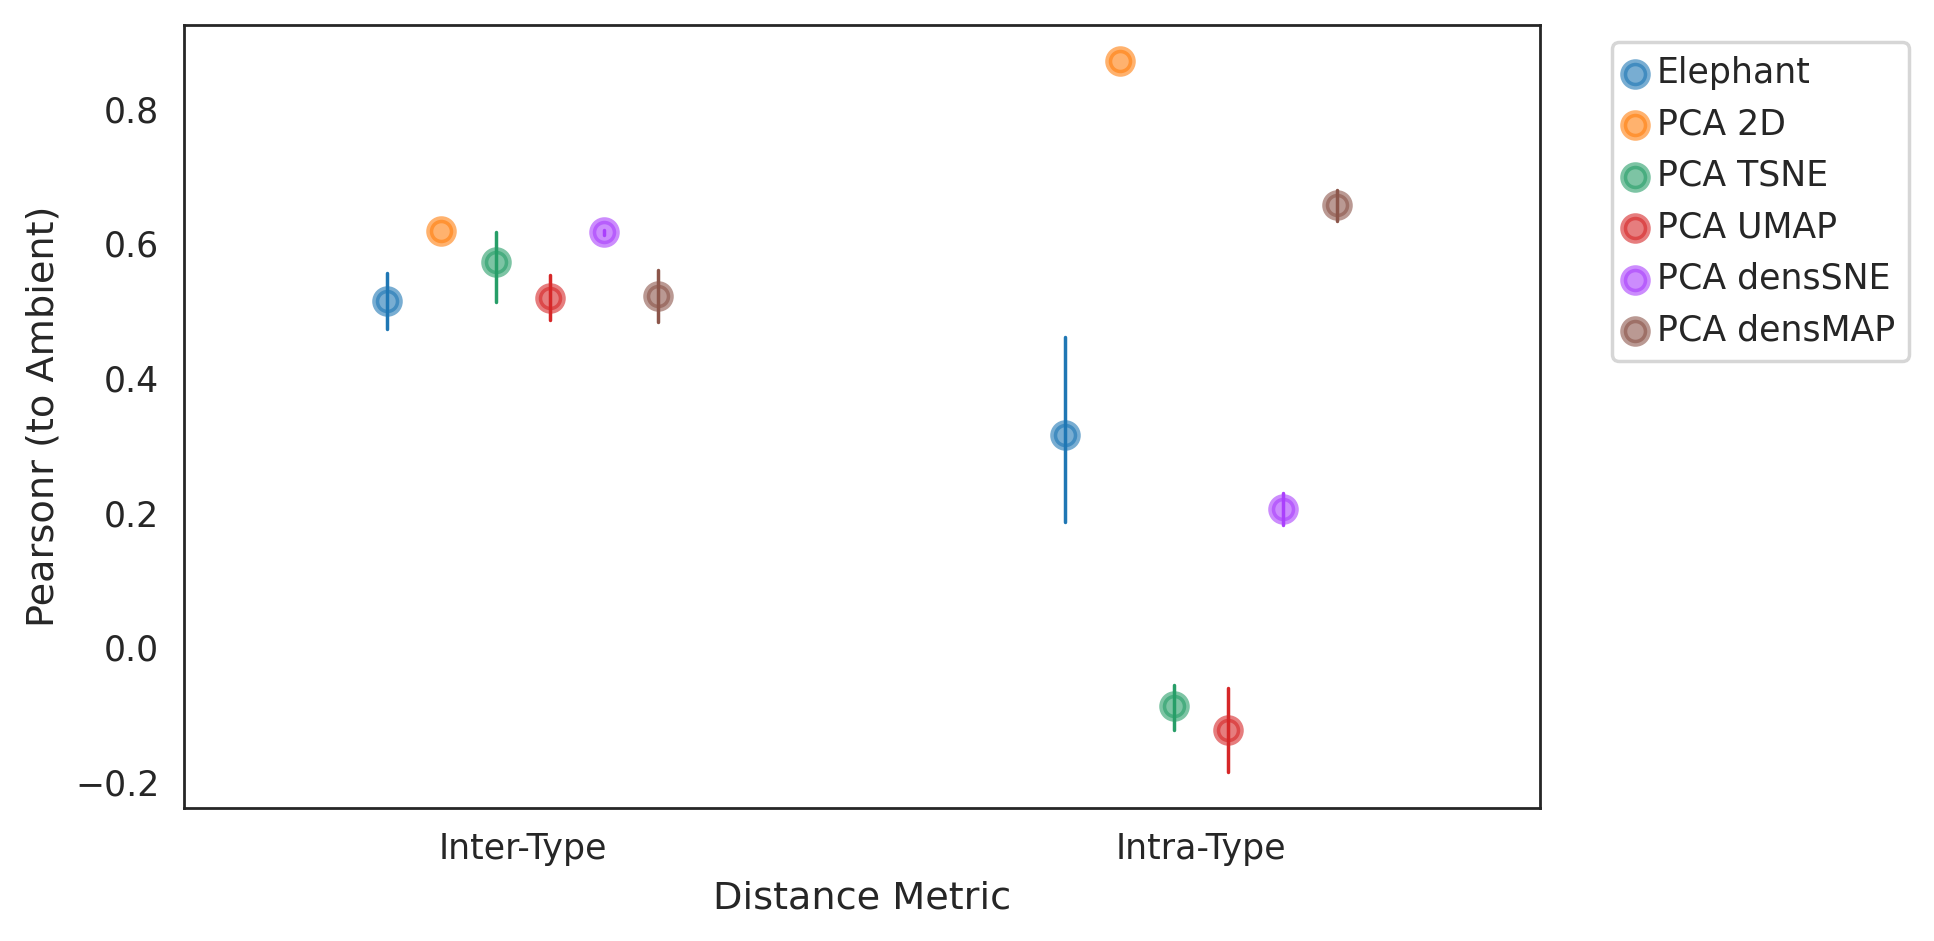

In [ ]:
plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10, fname = None)

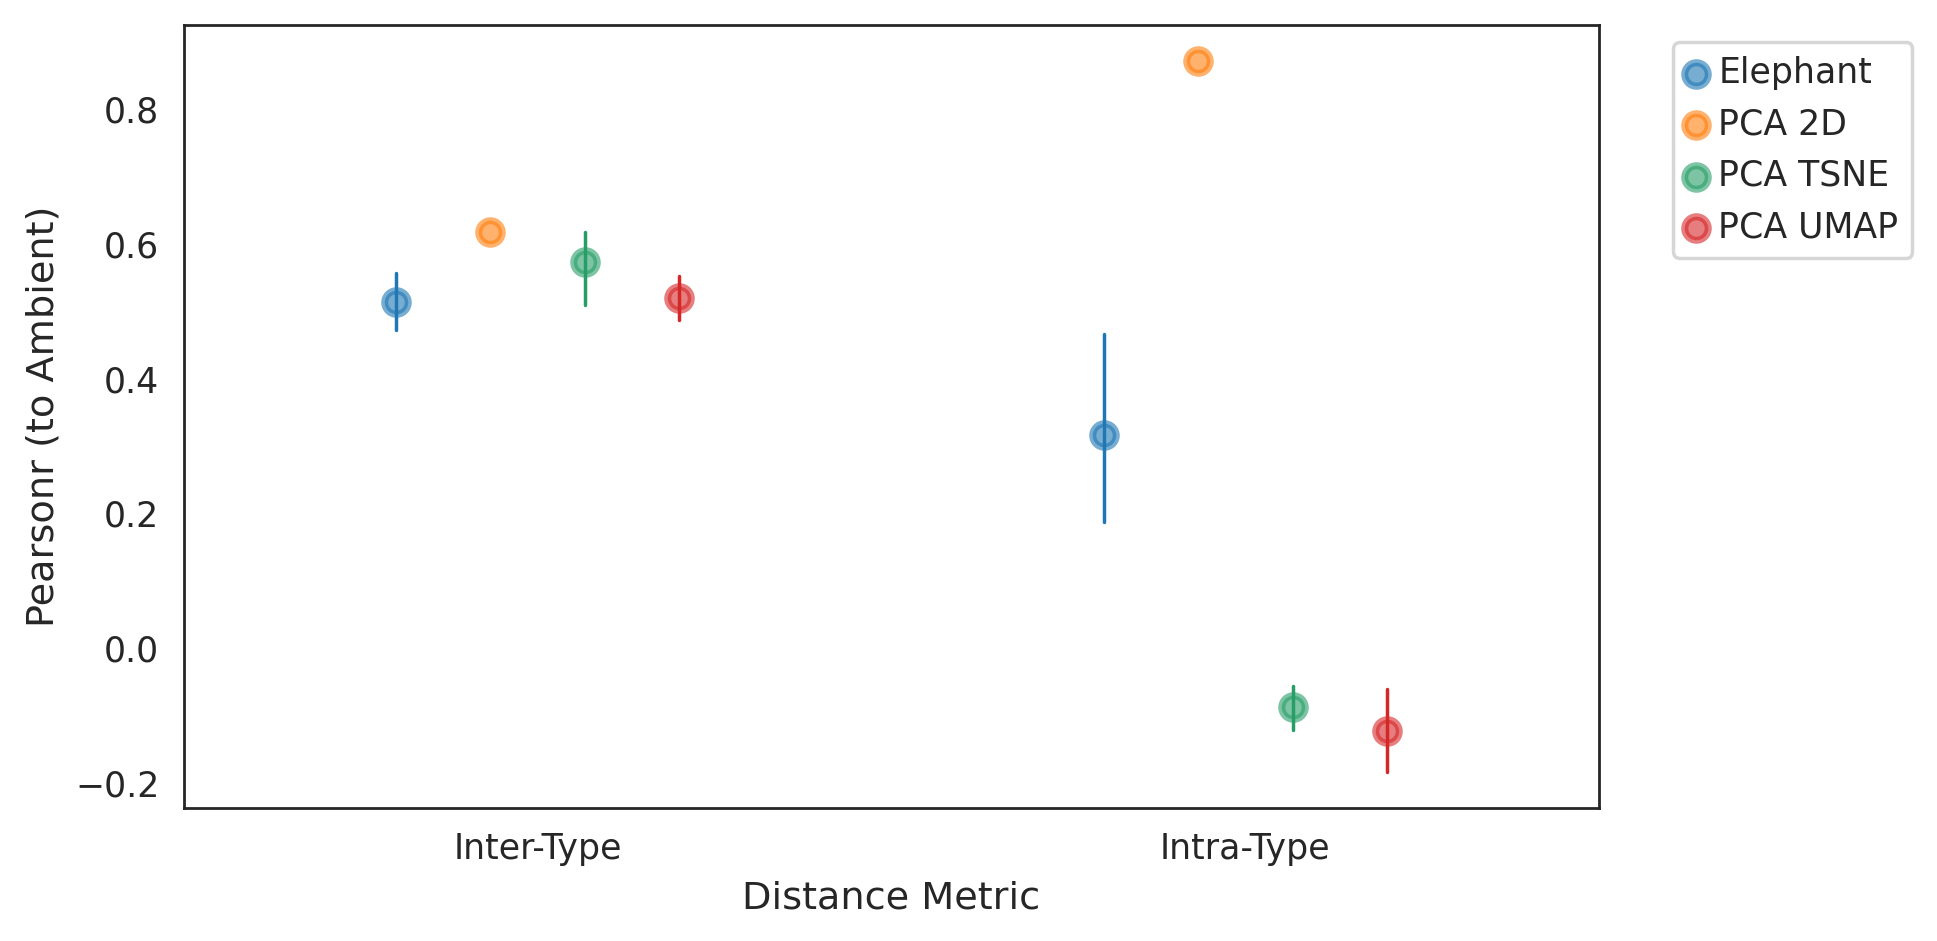

In [ ]:
plotLatentStats(subAllVals, axisFontSize = 11, tickFontSize = 10, fname = None)

In [ ]:
emb = []

vals = []

dist = []

dim = []

allVals = pd.DataFrame()

for p in range(len(latents)):

  i = latents[p]
  l = latentLab[p]
  d = latentType[p]

  c = tl.getCentroidDists(i, labs[0])
  intra = tl.getIntraVar(i, labs[0], labs[0])


  vals += [stats.pearsonr(c, amb)[0],stats.pearsonr(intra, ambIntra)[0]]
  dist += ['Inter-Type','Intra-Type']

  emb += [l]*2
  dim += [d]*2

allVals['Latent'] = emb
allVals['Distance'] = dist
allVals['Pearsonr'] = vals

In [ ]:

from google.colab import files

allVals.to_csv('merfishElVals.csv')


In [ ]:
files.download('merfishElVals.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>